*Import the standard packages and data:*

In [1]:
%run stdPackages.ipynb
slides = True # print to slides format if True
out_folder = os.path.join(d['curr'], 'Misc', 'Figs')
d['data'] = os.path.join(d['curr'],'Misc','Data')
read = {'variables': ['Fundamentals', 'Load', 'Generators_Other'], 
        'variable2D': ['Generators_FuelMix','HourlyVariation'],
        'scalars': ['Scalars'],
        'maps': ['Generators_Categories']}
# If you experience warning of the type "Future Warning", you can mute them using the following:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
db = dbFromWB(os.path.join(d['data'],'mBasicInt_StorageExperiment.xlsx'), read)
readSets(db)

In [2]:
from scipy.optimize import fsolve # Used for solving a system of #K non-linear equations with #K unknows: Used for calibrating the price elastic demand
from scipy.optimize import least_squares
from scipy.optimize import minimize
import scipy.interpolate as interpolate
import scipy.stats as stats
import seaborn as sns

# Equilibrium and Welfare Effects of Electricity Storage

Section 1-3 looks at the baseline equilibrium and the characteristics of the bottom-up model

## 1. The Baseline Model

*Start by setting up and solving the model with perfectly inelastic demand:*

In [3]:
m = mBasicInt.mSimple(db.copy())
m.solve()
db_base = m.db.copy()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


### 1.1. Plot merit order curve, marginal fuel consumption and marginal emissions for each hour:

*Define functions for making data series for supply and demand:*

In [4]:
def demand_h(m,h):
    return standardPlots.demandLinear_df(m.db['MWP_LoadShedding'], m.hourlyLoad.xs(h))
def supply_h(m,h,maxY=30):
    return standardPlots.meritOrderCurve_df(m.db['mc'], m.hourlyGeneratingCapacity.xs(h,level='h'),maxY=maxY)

*Define functions for making data series for marginal fuel consumption and emissions:*

In [5]:
def other_from_supply(h,mc,production,other):
    production = production.xs(h,level='h')
    df = pd.concat({**{'c':mc,'q':production},**{x:other[x] for x in other.columns}},axis=1).sort_values(by='c').drop(columns='c')
    df = df[df['q']>0]
    df['q'] = df['q'].cumsum()
    df_up = df.copy()
    df_up['q'] = df_up['q']+np.finfo(float).eps
    df_up[other.columns.values] = df_up[other.columns.values].shift(-1)
    df = df.append(df_up.dropna()).sort_values('q').set_index('q')
    df.loc[0] = [0]*len(other.columns)
    return df.sort_index()

*Now make the plot:*

In [6]:
%%capture
mult_graphs()
ncols = len(m.db['h'])
nrows = 3
nplots = ncols*nrows
df_supply = pd.DataFrame()

fig,axes = plt.subplots(nrows,ncols,figsize=(14,(4*nrows)),sharey='row',sharex=True);
offset_N, offset_Arrow, offset_q = 1, 1, 3
for row in range(nrows):
    for col in range(ncols):
        h = col+1
        if row==0:
            df = supply_h(m,h).rename(columns={'$Supply$':'Supply curve'})
            df.plot(linewidth=3,ax=axes[row][col],legend=False);
            df_supply = df_supply.append(df)
            axes[row][col].set_ylabel(r'$p_h$ ($€/$GJ)', labelpad = 5);
        if row==1:
            df = other_from_supply(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= m.db['FuelMix'].unstack('BFt'))
            agg_cols = {'Oil':['Fueloil','Gasoil'], 'Biomass':['Straw','WoodPellets','WoodChips','WoodWaste'],'Other Bio':['Biogas','BioOil']}
            for x in agg_cols.keys():
                df[x] = df[agg_cols[x]].sum(axis=1)
            df.drop(columns=[item for sublist in list(agg_cols.values()) for item in sublist],inplace=True) 
            df.plot(kind='area',linewidth=0,ax=axes[row][col],legend=False,stacked=True);
            axes[row][col].set_ylabel(r"$E^{'}_h$ (GJ input/GJ output)", labelpad = 5);
            axes[row][col].set_ylim([0, df.max().max()*1.4]);
            if col==1:
                fig.legend(handles=axes[row][col].get_legend_handles_labels()[0],loc='upper center', ncol=len(df.columns), frameon=True, bbox_to_anchor=(0.55,0.622))
        if row==2:
            df = other_from_supply(h=h,mc=m.db['mc'],production=m.hourlyGeneratingCapacity,other= mBasicInt.plantEmissionIntensity(m.db).unstack('EmissionType'))
            df['CO2'].multiply(1000).plot(kind='area',linewidth=0,ax=axes[row][col],legend=False,stacked=True);
            axes[row][col].set_ylabel(r"$M_h^{'}$ (kg CO$_2/$GJ)", labelpad = 5);
        axes[row][col].set_xlabel(r'$G_h=\sum_i G_{i,h}$ (GJ)', labelpad = 5);
        axes[row][col].set_xlim([0, df_supply.index.astype(float).max()+5]);
    

axes[0,0].set_title(r'$\bf{h=1}$ (off-peak)',pad=10)
axes[0,1].set_title(r'$\bf{h=2}$ (peak)',pad=10)

fig.tight_layout();
fig.subplots_adjust(hspace=0.05,top=0.9)
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Supply_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Supply.pdf",edgecolor='k')

## 2. Introduce Smooth Supply

*Get the basic parameters of the baseline model:*

In [7]:
p_base = m.db['marginalSystemCosts'].values # Hourly prices
TotD_base = m.db['Load'].astype(float).values[0] # Yearly demand
D_base = m.db['LoadVariation'].astype(float).values*TotD_base # Hourly demand
I = sum(D_base*p_base) # Total expenditures=Income
Expenditures = sum(m.db['HourlyDemand'].values*p_base)
p_index_base = I/TotD_base # Iniatal yearly price index
λ = 0.2 # Storage loss

*Define the smooth approximation:*

In [8]:
def smooth_supply(p,*params):
    mc,q,σ_s = params
    return (q*stats.norm.cdf((p[:,np.newaxis]-mc)/σ_s)).sum(axis=1)
def d_smooth_supply(p,*params):
    mc,q,σ_s = params
    return (q*np.exp(-0.5*((p[:,np.newaxis]-mc)/σ_s)**2)).sum(axis=1)/(np.sqrt(2*math.pi)*σ_s)
    # return (q*stats.norm.pdf((p[:,np.newaxis]-mc)/σ_s)).sum(axis=1)/σ_s

*Specify price grids:*

In [9]:
p_grid = np.linspace(0.1,m.db['MWP_LoadShedding']*1.5,endpoint=True,num=99)
p1 = np.sort(np.append(p_grid,np.array([p_base[0]])))
p2 = np.sort(np.append(p_grid,np.array([p_base[1]])))
p = np.array([p1,p2]).reshape(2,100)

*Specify techno-economic parameters:*

In [10]:
mc = m.db['mc'].astype(float).sort_index().values.reshape(1,len(m.db['mc']))
q = m.hourlyGeneratingCapacity.unstack('id').sort_index().astype(float).values
# Set smoothing parameter
σ_s_grid = [3,1]

*Make the plot:*

In [11]:
%%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    h = j+1
    # Plot kinked supply
    df = supply_h(m,h).rename(columns={'$Supply$':r'$\sigma_s\rightarrow 0$'})
    df.plot(linewidth=3,ax=axes[j],legend=False);
    # Plot smooth supply
    for i in range(len(σ_s_grid)):
        S = np.array([smooth_supply(np.array([p1,p2]),*(mc,q,σ_s_grid[i])) for p1,p2 in zip(p1,p2)])
        axes[j].plot(S[:,j],p[j],linewidth=3,label=f"""$\sigma_d=${σ_s_grid[i]}""");
    # Axes
    axes[j].set_xlabel(r'$\sum_i G_{i,h}$', labelpad = 5);
    axes[j].set_ylabel(r'$p_h$', labelpad = 5);
    axes[j].set_xlim([0, df.index.max()+5]);
    axes[j].set_ylim([0, math.ceil(p_grid.max()*1.1)]);
    axes[j].set_title(f"""$h={h}$""")
    
fig.legend(handles=axes[j].get_legend_handles_labels()[0],loc=9,ncol=4,frameon=True,bbox_to_anchor=(0.5, 1.15))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_SmoothMeritOrder_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_SmoothMeritOrder.pdf",edgecolor='k',bbox_inches='tight')

## 3. Introduce Price Elastic Demand

*Now we define a price-elastic demand function, given by a Constant Elasticity of Substitution Function:*

In [12]:
# Function defining the price index
def p_index(p,*params):
    μ,σ_d = params
    if σ_d!=1:
        return (μ*p**(1-σ_d)).sum(axis=0)**(1/(1-σ_d))
    else:
        return ((p)**(μ)).prod(axis=0)

# Function defining the Marshallian demand
def demand(p,*params):
    μ,σ_d,I = params
    if σ_d==0:
        p_i = p_index(p,*(μ,σ_d))
        return μ*I/p_i
    elif σ_d==1:
        return μ*I/p
    else:
        p_i = p_index(p,*(μ,σ_d))
        return μ*(p/p_i)**(-σ_d)*I/p_i

# Derivative of price index
def d_p_index(p,*params):
    μ,σ_d,p_index_val = params
    if σ_d!=1:
        if σ_d==0:
            return μ
        else:
            return (p_index_val/p)**σ_d*μ

# Derivative of demand
def d_demand(p,*params):
    μ,σ_d,I = params
    H = len(μ)
    d_D = np.zeros((H,H))
    common = μ*I
    if σ_d!=1:
        p_index_val = p_index(p,*(μ,σ_d))
        d_p_index_val = d_p_index(p,*(μ,σ_d,p_index_val))
        if σ_d==0:
            tmp = p_index_val**2
            d_D[0,0] = -common[0]*d_p_index_val[0]
            d_D[0,1] = -common[0]*d_p_index_val[1]
            d_D[1,0] = -common[1]*d_p_index_val[0]
            d_D[1,1] = -common[1]*d_p_index_val[1]
            d_D = d_D/tmp
        else:
            d_Dj_pi = (σ_d-1)*p_index_val**(σ_d-2)*d_p_index_val
            d_Dj_pj = -σ_d*p**(-σ_d-1)*p_index_val**(σ_d-1)
            d_D[0,0] = common[0]*(d_Dj_pj[0]+d_Dj_pi[0]*p[0]**(-σ_d))
            d_D[0,1] = common[0]*d_Dj_pi[1]*p[0]**(-σ_d)
            d_D[1,0] = common[1]*d_Dj_pi[0]*p[1]**(-σ_d)
            d_D[1,1] = common[1]*(d_Dj_pj[1]+d_Dj_pi[1]*p[1]**(-σ_d))
    else:
        d_Dj_pj = -common/p**2
        d_D[0,0] = d_Dj_pj[0]
        d_D[1,1] = d_Dj_pj[1]
    return d_D
    

# Function for calibrating the share parameters of the CES function to the baseline scenario for a given σ_d. 
def calibrate_μ(params):
    p,σ_d,I,D = params
    if (isinstance(σ_d, str)==False):
        return D*p**σ_d/I
    else:
        return np.zeros(len(m.db['h']))

# Function for defining utility
def indirect_utility(p,*params):
    μ,σ_d,I = params
    return I/p_index(p,*(μ,σ_d))

# Function for drawing contour lines
def indifference_curves(D1,*params):
    μ,σ_d,u = params
    if σ_d==0:
        return None
    if σ_d==1:
        return (u/(D1**μ[0]))**(1/μ[1])
    else:
        return ((u**((σ_d-1)/σ_d)-μ[0]**(1/σ_d)*D1**((σ_d-1)/σ_d))/μ[1]**(1/σ_d))**(σ_d/(σ_d-1))

*Plot price elasticities in the baseline scenario:*

In [13]:
σ_d_grid = ['Perfectly inelastic',0,0.5,1,2,7]
σ_d_labels = {
    'Perfectly inelastic':'Perfectly inelastic',
    0:'$\sigma_d=$0 (Perfect complements)',
    0.5:'$\sigma_d=$0.5 (Gross complements)',
    1:'$\sigma_d=$1 (Cobb-Douglas)',
    2:'$\sigma_d=$2 (Gross substitutes)',
    7: '$\sigma_d=$9 (High substitutes)',
}
D1_grid = np.concatenate(
    [np.linspace(1,D_base[0],100),
     np.linspace(D_base[0]+np.finfo(float).eps,q.cumsum(axis=1).max()*1.5,50)],
    dtype=float)
D2_grid = D1_grid.copy()
μs = {σ_d:calibrate_μ((p_base,σ_d,I,D_base)) for σ_d in σ_d_grid}

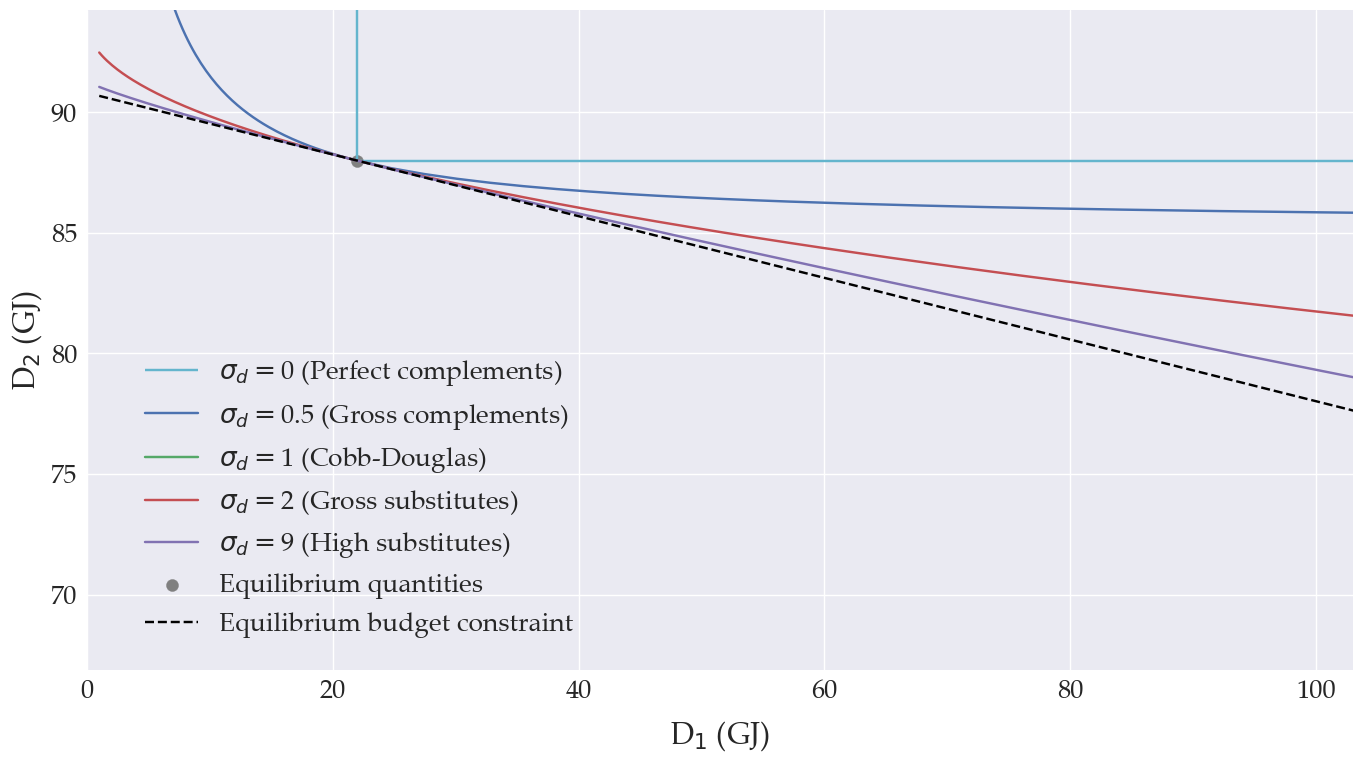

In [14]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
# Indifference curves
for σ_d in σ_d_grid[1:]:
    if σ_d==0:
        u = indirect_utility(p_base,*(μs[σ_d],σ_d,I))
        D1_min = μs[σ_d][0]*u
        D2_min = μs[σ_d][1]*u
        ax.vlines(D1_min, D2_min, D2_grid.max(),color=colors[5],label=σ_d_labels[σ_d])
        ax.hlines(D2_min, D1_min, D1_grid.max(),color=colors[5])
    else:
        D2 = np.array([indifference_curves(D1,*(μs[σ_d],σ_d,indirect_utility(p_base,*(μs[σ_d],σ_d,I)))) for D1 in D1_grid])
        cond = (D2>0) & (D2<D2_grid.max())
        ax.plot(D1_grid[cond],D2[cond],label=σ_d_labels[σ_d])
# Equilibrium quantities:
ax.scatter(D_base[0],D_base[1],label='Equilibrium quantities',color='grey',s=75)
# Budget constraint
D2 = (I-p_base[0]*D1_grid)/p_base[1]
ax.plot(D1_grid,D2,label='Equilibrium budget constraint',linestyle='--',color='black')

# Maximmum capacity
q_max = q.cumsum(axis=1).max(axis=1)
ylim = ax.get_ylim()
xlim = [0,D1_grid.max()+5]
# ax.vlines(q_max[0],ymin=ylim[0],ymax=ylim[1],label='Accumulated generation capacity',color='grey')
# ax.hlines(q_max[1],xmin=xlim[0],xmax=xlim[1],color='grey')

ax.set_xlabel(r'D$_1$ (GJ)', labelpad=10);
ax.set_ylabel(r'D$_2$ (GJ)', labelpad = 5);
ax.set_ylim([ylim[0],q_max[1]])
ax.set_xlim([xlim[0],q_max[0]])
fig.legend(loc='lower left',bbox_to_anchor=(0.1, 0.15))
fig.tight_layout();
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_IndifferenceCurves_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_IndifferenceCurves.pdf",edgecolor='k',bbox_inches='tight')

### 3. Plot equilibrium

*First making the correct series:*

In [15]:
p_grid = np.linspace(0.1,m.db['MWP_LoadShedding']*1.5,endpoint=True,num=99)
p1 = np.sort(np.append(p_grid,np.array([p_base[0]])))
p2 = np.sort(np.append(p_grid,np.array([p_base[1]])))
p = np.array([p1,p2]).reshape(2,100)

# Supply
mc = m.db['mc'].astype(float).sort_index().values.reshape(1,len(m.db['mc']))
q = m.hourlyGeneratingCapacity.unstack('id').sort_index().astype(float).values

*Now make the plot:*

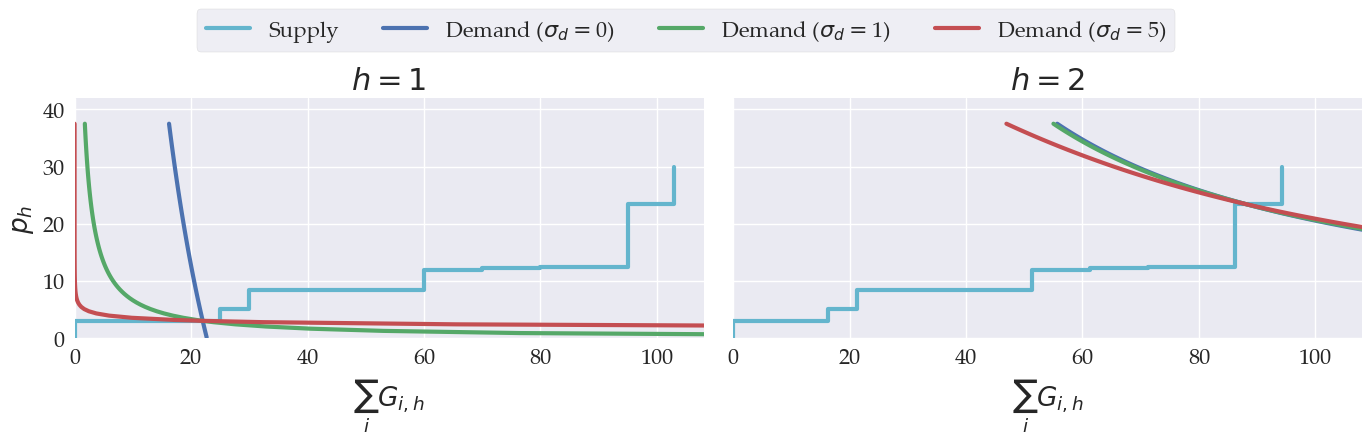

In [16]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    h = j+1
    df = supply_h(m,h).rename(columns={'$Supply$':'Supply'})
    
    df.plot(linewidth=3,ax=axes[j],legend=False,color=colors[5]);
    for σ_d in [0,1,5]:
        # Calibrate CES parameters by normalizing price index to 1:
        μ = calibrate_μ(params=(p_base,σ_d,I,D_base))

        # Update flexible demand
        E1 = [demand(np.array([p,p_base[1]]),*(μ,σ_d,I))[0] for p in p1]
        E2 = [demand(np.array([p_base[0],p]),*(μ,σ_d,I))[1] for p in p2]
        E = np.array([E1,E2]).reshape(2,100)
        axes[j].plot(E[j],p[j],linewidth=3,label=r'Demand ($\sigma_d=$'+str(σ_d)+')');
    
    axes[j].set_xlabel(r'$\sum_i G_{i,h}$', labelpad = 5);
    axes[j].set_ylabel(r'$p_h$', labelpad = 5);
    axes[j].set_xlim([0, q.cumsum(axis=1).max()+5]);
    axes[j].set_ylim([0, math.ceil(p_grid.max()*1.1)]);
    axes[j].set_title(f"""$h={h}$""")
    
fig.legend(handles=axes[j].get_legend_handles_labels()[0],loc=9,ncol=5,frameon=True,bbox_to_anchor=(0.5, 1.15))    
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_BaselineEquilibrium_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_BaselineEquilibrium.pdf",edgecolor='k',bbox_inches='tight')

## 4. Solve model with increasing storage capacity

*Specify non-linear model:*

In [17]:
def excess_supply(p,*params):
    mc,q,σ_s,μ,σ_d,I,S0,λ = params
    S = smooth_supply(p,*(mc,q,σ_s))
    D = demand(p,*(μ,σ_d,I))
    return np.array([S[0]-D[0]-S0,S[1]-D[1]+(1-λ)*S0])

def excess_supply_jac(p,*params):
    mc,q,σ_s,μ,σ_d,I,S0,λ = params
    d_D = d_demand(p,*(μ,σ_d,I))
    d_S = d_smooth_supply(p,*(mc,q,σ_s))
    jac = np.zeros(d_D.shape)
    jac[0,0] = d_S[0]-d_D[0,0]
    jac[0,1] = -d_D[0,1]
    jac[1,0] = -d_D[1,0]
    jac[1,1] = d_S[1]-d_D[1,1]
    return jac

def inverse_jacobian(p,*params):
    mc,q,σ_s,μ,σ_d,I,S0,λ = params
    d_D = d_demand(p,*(μ,σ_d,I))
    d_S = d_smooth_supply(p,*(mc,q,σ_s))
    det = (d_S[0]-d_D[0,0])*(d_S[1]-d_D[1,1]) - d_D[0,1]*d_D[1,0]
    out = np.zeros(d_D.shape)
    out[0,0] = d_S[1] - d_D[1,1]
    out[0,1] = d_D[1,0]
    out[1,0] = d_D[0,1]
    out[1,1] = d_S[0] - d_D[0,0]
    return out/det

def solve_by_newton(p0=None,n_iter=100,tol=1e-8,args=None,full_output=False):
    ES = excess_supply(p0,*args)
    p = p0.copy()
    i = 0
    while ((abs(ES)>tol).sum()>0) & (i<=n_iter):
        p = p - np.matmul(inverse_jacobian(p,*args),ES)
        ES = excess_supply(p,*args)
        i+=1
    if full_output:
        out = {}
        out['n_iter'] = i
        out['p'] = p
        out['ES'] = ES
        out['succes'] = ((ES>tol).sum()==0)
        return out
    else:
        return p

def MSE_excess_supply(p,*params):
    mc,q,σ_s,μ,σ_d,I,S0,λ = params
    ES = excess_supply(p,*(mc,q,σ_s,μ,σ_d,I,S0,λ))
    return 0.5*(ES**2).sum()

*Define how to search for cornor solutions (i.e. vertical lines on the supply curve)*

In [18]:
def solve_for_demand(x,*params):
    μ,σ_d,I,p,D,state=params
    if state==1:
        DD = demand(np.array([p,x[1]]),*(μ,σ_d,I))
        return np.array([
            x[0] - DD[0],
            D - DD[1]
        ])
    elif state==0:
        DD = demand(np.array([x[1],p]),*(μ,σ_d,I))
        return np.array([
            D - DD[0],
            x[0] - DD[1]
        ])
    elif state=='prices':
        DD = demand(np.array([x[0],x[1]]),*(μ,σ_d,I))
        return np.array([
            D[0] - DD[0],
            D[1] - DD[1]
        ])
    elif state=='demand':
        DD = demand(np.array(p),*(μ,σ_d,I))
        return np.array([
            x[0] - DD[0],
            x[1] - DD[1]
        ])
    
def MSE_demand(x,*params):
    μ,σ_d,I,p,D,state=params
    return 0.5*((solve_for_demand(x,*(μ,σ_d,I,p,D,state)))**2).sum()

*Define what to extract from the LP model:*

In [19]:
def extract_from_LPmodel(m,demand,p,σ_d,S0):
    
    p = pd.Series(p,index=m.db['marginalSystemCosts'].index,name=m.db['marginalSystemCosts'].name)
    # a) Update demand for linear model:
    S_NLmodel = demand + np.array([S0,-(1-λ)*S0])
    TotSupply = sum(S_NLmodel)
    m.db['Load'] = pd.Series([TotSupply],index=m.db['Load'].index,name='Load')
    m.db['HourlyDemand'] = pd.Series(S_NLmodel,index=m.db['HourlyDemand'].index,name='HourlyDemand')
    m.db['LoadVariation'] = pd.Series(m.db['HourlyDemand'].values/m.db['Load'].sum(),index=m.db['LoadVariation'].index,name='LoadVariation')

    # b) Solve linear programming model:
    m.solve(printSol=False);
    
    # c) Extract
    Generation = m.db['Generation'].groupby('id').agg('sum')
    PracticalCapFactor = (Generation/m.hourlyGeneratingCapacity.groupby('id').agg('sum').replace(0,np.inf))
    FOM = m.db['FOM']*1000*len(m.db['h'])/8760
    marginalEconomicValue = (p*m.db['Generation']-m.db['mc']*m.db['Generation']-FOM*m.db['Generation']/m.db['Generation'].replace(0,np.inf)).groupby('id').agg('sum')
    id2tech = {x[0]:x[1] for x in db['id2tech']}
    Profits = (p*m.db['Generation']-m.db['mc']*m.db['Generation']).groupby('id').agg('sum')
    out = pd.concat({
        'Generation':Generation,'PracticalCapacityFactor':PracticalCapFactor,'marginalEconomicValue':marginalEconomicValue,
        'Profits':Profits
    },axis=1).rename(id2tech,level='id').astype(float)
    out = out.groupby(['id']).agg({x:'sum' if x!='PracticalCapacityFactor' else 'mean' for x in out.columns}).rename_axis(['Agent'])
    out.index = pd.MultiIndex.from_tuples([(σ_d,S0,x) for x in out.index],names=['$\sigma_d$','S$_0$','Agent'])
    return out

*Create loop on the storage level:*

In [20]:
# Loop length
loop = pd.Index(range(100), name = 'loop')

# Off-peak grid
v0 = pd.Series(db['LoadVariation'].min(), index = pd.Index(['c1'], name = 'c')) # 'id4' is the wind plant
vT = pd.Series(0.40, index = pd.Index(['c1'], name = 'c'))
OffPeakGrid = addGrid(v0, vT, loop, 'LoadVariation')# inputs are (1) first value in grid, (2) final value, (3) loop, (4) name of symbol
OffPeakGrid.index = pd.MultiIndex.from_tuples([(a[0],a[1],1) for a in OffPeakGrid.index], names=OffPeakGrid.index.names+['h'])

# Peak grid
step = OffPeakGrid.diff().fillna(0)
S0_grid = (step.cumsum()*db['Load']).astype(float).values
PeakGrid = pd.Series([db['LoadVariation'].max()-(1-λ)*s[-1]*s[0][0] for s in step.iteritems()],index=OffPeakGrid.rename({1:2},level='h').index,name='LoadVariation').sort_index()

# Common grid
LoadVariationGrid = OffPeakGrid.append(PeakGrid).sort_index()

*Define supply curve kinks:*

In [21]:
df_kink = pd.concat({'p':m.db['mc'].astype(float),'q':m.hourlyGeneratingCapacity.unstack('h').astype(float)},axis=1)
df_kink.columns = ['p',1,2]
df_kink = df_kink.groupby('p').agg('sum').reset_index()
df_kink = df_kink.sort_values('p')
df_kink[[1,2]] = df_kink[[1,2]].cumsum()
df_kink['p_up'] = df_kink['p'].shift(-1)
df_kink['1_down'] = df_kink[1].shift(1).fillna(0)
df_kink['2_down'] = df_kink[2].shift(1).fillna(0)
df_kink.iloc[len(df_kink)-1,3] = m.db['MWP_LoadShedding']

S1_interval, S2_interval = pd.arrays.IntervalArray.from_arrays(df_kink['1_down'], df_kink[1],closed='both'), pd.arrays.IntervalArray.from_arrays(df_kink['2_down'],df_kink[2],closed='both')
p_interval = pd.arrays.IntervalArray.from_arrays(df_kink['p'], df_kink['p_up'],closed='both')

*Solve model in nested for-loops:*

In [22]:
df_results = pd.DataFrame()
df_plants = pd.DataFrame()
σ_s_grid = [2,1,0.5,0.25,0.1,0.05]
d_σ_s_grid = {σ_d: σ_s_grid if σ_d==0 else σ_s_grid + [0.01,0.005] for σ_d in σ_d_grid[1:]}
for σ_d in σ_d_grid:
    print(f"""σ={σ_d}""")
    # Calibrate CES parameters by normalizing price index to 1:
    p_tmp = p_base.copy()
    μ = μs[σ_d]

    # Restart model
    m.db = db_base.copy()
        
    for S0 in S0_grid:
        index = pd.MultiIndex.from_tuples([(σ_d,S0,h) for h in [1,2]],names=['$\sigma_d$','S$_0$','h'])
        if isinstance(σ_d,str):
            m.db['Load'] = db_base['Load']+λ*S0
            m.db['HourlyDemand'] = db_base['HourlyDemand'] + np.array([S0,-(1-λ)*S0])
            m.db['LoadVariation'] = pd.Series(m.db['HourlyDemand'].values/m.db['Load'].values,index=m.db['LoadVariation'].index,name='LoadVariation')
            p_tmp = m.db['marginalSystemCosts'].values
            D = m.db['HourlyDemand'].values - np.array([S0,-(1-λ)*S0])
            S = m.db['HourlyDemand'].values
            df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
            p_t = sum(p_tmp*D/sum(D))
            Emis = m.db['Emissions'].copy()
            if (1-λ)*p_tmp[1]>=p_tmp[0]:
                df_r_tmp = pd.concat(
                    [pd.Series(p_tmp,index=index,name='p'),
                     pd.Series([p_t,p_t],index=index,name='p_index'),
                     pd.Series(D,index=index,name='D'),
                     pd.Series(S,index=index,name='S')] +
                    [pd.Series([Emis[x],Emis[x]],index=index,name=x) for x in Emis.index]
                    ,axis=1)
                df_results = df_results.append(df_r_tmp)
                df_plants = df_plants.append(df_plant)
        else:
            # Solve NonLinear programming model:
            k = 0
            sol = {}
            for i in range(len(d_σ_s_grid[σ_d])):
                σ_s = d_σ_s_grid[σ_d][i]
                sol[i] = fsolve(excess_supply,x0=p_tmp,args=(mc,q,σ_s,μ,σ_d,I,S0,λ),fprime=excess_supply_jac,full_output=True) #,fprime=excess_supply_jacobian
                p_tmp = sol[i][0] if (sol[i][-1]=='The solution converged.') else sol[i-1][0]
            p_NLmodel = p_tmp.copy()
            D_NLmodel = demand(p_tmp,*(μ,σ_d,I))
            S_NLmodel = smooth_supply(p_tmp,*(mc,q,σ_s))
            
            
            # Both on horisontal lines:
            while k==0:
                cond1, cond2 = [S_NLmodel[0] in x for x in S1_interval], [S_NLmodel[1] in x for x in S2_interval]
                p1 = df_kink['p'][cond1].values[0]
                p2 = df_kink['p'][cond2].values[0]
                D1_range = [df_kink.loc[cond1,'1_down'].values[0]-S0,df_kink.loc[cond2,1].values[0]-S0]
                D2_range = [df_kink.loc[cond2,'2_down'].values[0]+(1-λ)*S0,df_kink.loc[cond2,2].values[0]+(1-λ)*S0]
                sol = fsolve(solve_for_demand,x0=[D_NLmodel[0],D_NLmodel[1]],args=(μ,σ_d,I,[p1,p2],None,'demand'),full_output=True)
                D1, D2 = (sol[0][0],sol[0][1]) if sol[-1]=='The solution converged.' else (np.inf,np.inf)
                if (D2_range[0]<=D2<=D2_range[1]) & (D1_range[0]<=D1<=D1_range[1]):
                    p_tmp = np.array([p1,p2])
                    D = np.array([D1,D2])
                    S = D+np.array([S0,-(1-λ)*S0])
                    p_t = p_index(p_tmp,*(μ,σ_d))
                    df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
                    Emis = m.db['Emissions'].copy()
                    k+=1
                    break
                # If horizontal line in h=1 and vertical line in h=2:
                S2_con = np.isclose(df_kink[2],S_NLmodel[1],atol=2)
                cond = [S_NLmodel[0] in x for x in S1_interval]
                D2 = df_kink[2][S2_con].values[0]+(1-λ)*S0
                p1 = df_kink.loc[cond,'p'].values[0]
                p2_range = [df_kink.loc[S2_con,'p'].values[0],df_kink.loc[S2_con,'p_up'].values[0]]
                D1_range = [x-S0 for x in [df_kink.loc[cond,'1_down'].values[0],df_kink.loc[cond,1].values[0]]]
                sol = fsolve(solve_for_demand,x0=[D_NLmodel[0],p_NLmodel[1]],args=(μ,σ_d,I,p1,D2,1),full_output=True)
                D1, p2 = (sol[0][0],sol[0][1]) if sol[-1]=='The solution converged.' else (np.inf,np.inf)
                if (p2_range[0]<=p2<=p2_range[1]) & (D1_range[0]<=D1<=D1_range[1]):
                    p_tmp = np.array([p1,p2])
                    D = np.array([D1,D2])
                    S = D+np.array([S0,-(1-λ)*S0])
                    p_t = p_index(p_tmp,*(μ,σ_d))
                    df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
                    Emis = m.db['Emissions'].copy()
                    k+=1
                    break
                # If vertical line in h=1 and horizontal line in h=2:
                S1_con = np.isclose(df_kink[1],S_NLmodel[0],atol=2)
                cond = [S_NLmodel[1] in x for x in S2_interval]
                D1 = df_kink[1][S1_con].values[0]-S0
                p2 = df_kink.loc[cond,'p'].values[0]
                p1_range = [df_kink.loc[S1_con,'p'].values[0],df_kink.loc[S1_con,'p_up'].values[0]]
                D2_range = [x+(1-λ)*S0 for x in [df_kink.loc[cond,'2_down'].values[0],df_kink.loc[cond,2].values[0]]]
                sol = fsolve(solve_for_demand,x0=[D_NLmodel[1],p_NLmodel[0]],args=(μ,σ_d,I,p2,D1,0),full_output=True)
                D2, p1 = (sol[0][0],sol[0][1]) if sol[-1]=='The solution converged.' else (np.inf,np.inf)
                if (p1_range[0]<=p1<=p1_range[1]) & (D2_range[0]<=D2<=D2_range[1]):
                    p_tmp = np.array([p1,p2])
                    D = np.array([D1,D2])
                    S = D+np.array([S0,-(1-λ)*S0])
                    p_t = p_index(p_tmp,*(μ,σ_d))
                    df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
                    Emis = m.db['Emissions'].copy()
                    k+=1
                    break
                # If both on veritcal line:
                S1_con, S2_con = np.isclose(df_kink[1],S_NLmodel[0],atol=2), np.isclose(df_kink[2],S_NLmodel[1],atol=2)
                D1 = df_kink[1][S1_con].values[0]-S0
                D2 = df_kink[2][S2_con].values[0]+(1-λ)*S0
                p1_range = [df_kink.loc[S1_con,'p'].values[0],df_kink.loc[S1_con,'p_up'].values[0]]
                p2_range = [df_kink.loc[S2_con,'p'].values[0],df_kink.loc[S2_con,'p_up'].values[0]]
                sol = fsolve(solve_for_demand,x0=[p_NLmodel[0],p_NLmodel[1]],args=(μ,σ_d,I,None,[D1,D2],'prices'),full_output=True)
                p1, p2 = (sol[0][0],sol[0][1]) if sol[-1]=='The solution converged.' else (np.inf,np.inf)
                if (p1_range[0]<=p1<=p1_range[1]) & (p2_range[0]<=p2<=p2_range[1]):
                    p_tmp = np.array([p1,p2])
                    D = np.array([D1,D2])
                    S = D+np.array([S0,-(1-λ)*S0])
                    p_t = p_index(p_tmp,*(μ,σ_d))
                    df_plant = extract_from_LPmodel(m,D,p_tmp,σ_d,S0)
                    Emis = m.db['Emissions'].copy()
                    k+=1
                    break
            if (1-λ)*p_tmp[1]>=p_tmp[0]:
                df_r_tmp = pd.concat(
                    [pd.Series(p_tmp,index=index,name='p'),
                     pd.Series([p_t,p_t],index=index,name='p_index'),
                     pd.Series(D,index=index,name='D'),
                     pd.Series(S,index=index,name='S')] +
                    [pd.Series([Emis[x],Emis[x]],index=index,name=x) for x in Emis.index]
                    ,axis=1)
                df_results = df_results.append(df_r_tmp)
                df_plants = df_plants.append(df_plant)
print('Finished')

σ=Perfectly inelastic
σ=0
σ=0.5
σ=1
σ=2
σ=7
Finished


In [23]:
df_results = df_results.sort_index()
df_results['p_index_base'] = df_results.merge(df_results['p_index'].xs(0,level='S$_0$').rename('p_index_base'),left_index=True,right_index=True)['p_index_base'].reorder_levels(df_results.index.names).sort_index()
df_results['p_t'] = df_results['D']*df_results['p']/df_results.groupby(df_results.droplevel('h').index.names)['D'].transform('sum')
df_results['p_t'] = df_results.groupby(df_results.droplevel('h').index.names)['p_t'].transform('sum')
df_results['μ'] = df_results.merge(pd.DataFrame(μs).stack().rename_axis(['h','$\sigma_d$']).rename({0:1,1:2},level='h').rename('μ'),left_index=True,right_index=True,how='outer')['μ'].reorder_levels(df_results.index.names).sort_index()
df_results['p_base'] = df_results.merge(pd.DataFrame(p_base).rename_axis('h').rename({0:1,1:2},axis=0)[0].rename('p_base'),left_index=True,right_index=True,how='outer')['p_base'].reorder_levels(df_results.index.names).sort_index()
df_results['D_base'] = df_results.merge(pd.DataFrame(D_base).rename_axis('h').rename({0:1,1:2},axis=0)[0].rename('D_base'),left_index=True,right_index=True,how='outer')['D_base'].reorder_levels(df_results.index.names).sort_index()

*Change labels:*

In [24]:
df_plants = df_plants.rename(σ_d_labels,level='$\sigma_d$')
df_results = df_results.rename(σ_d_labels,level='$\sigma_d$')

*Plot marginal value of storage:*

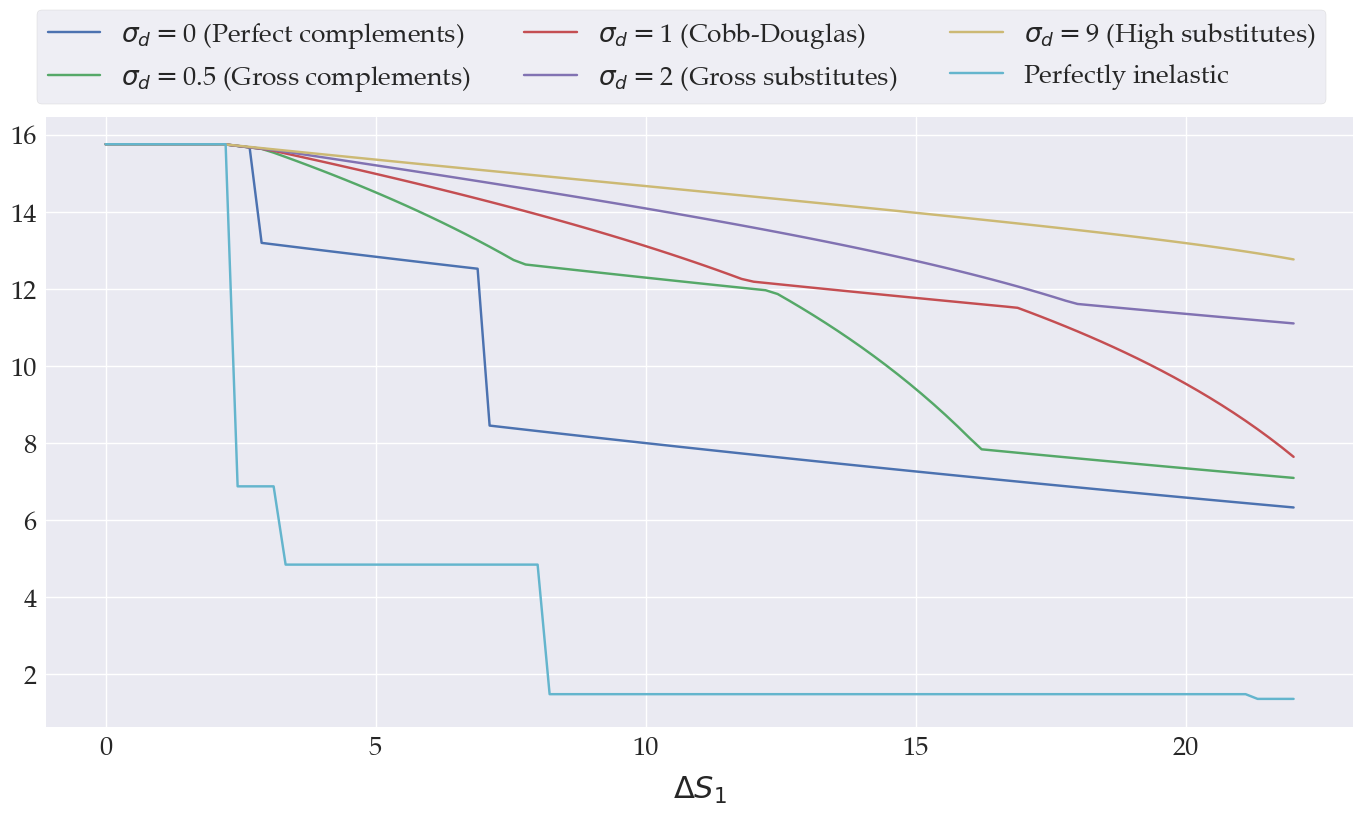

In [25]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
# df_tmp = ((1-λ)*df_results['p'].xs(2,level='h')-df_results['p'].xs(1,level='h'))
# ((df_tmp-df_tmp.xs(0,level='S$_0$'))).unstack('$\sigma_d$').plot(ax=ax,legend=False)
((1-λ)*df_results['p'].xs(2,level='h')-df_results['p'].xs(1,level='h')).unstack('$\sigma_d$').plot(ax=ax,legend=False)
ax.set_xlabel(r'$\Delta S_1$', labelpad=10);
# ax.set_ylabel(r"$\partial \pi/\partial S_1$", labelpad = 5);

fig.legend(df_results.index.get_level_values('$\sigma_d$').sort_values().unique(),
            loc=9,ncol=math.ceil(len(df_results.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.05))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_StorageValue1_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_StorageValue1.pdf",edgecolor='k',bbox_inches='tight')

*Plot prices:*

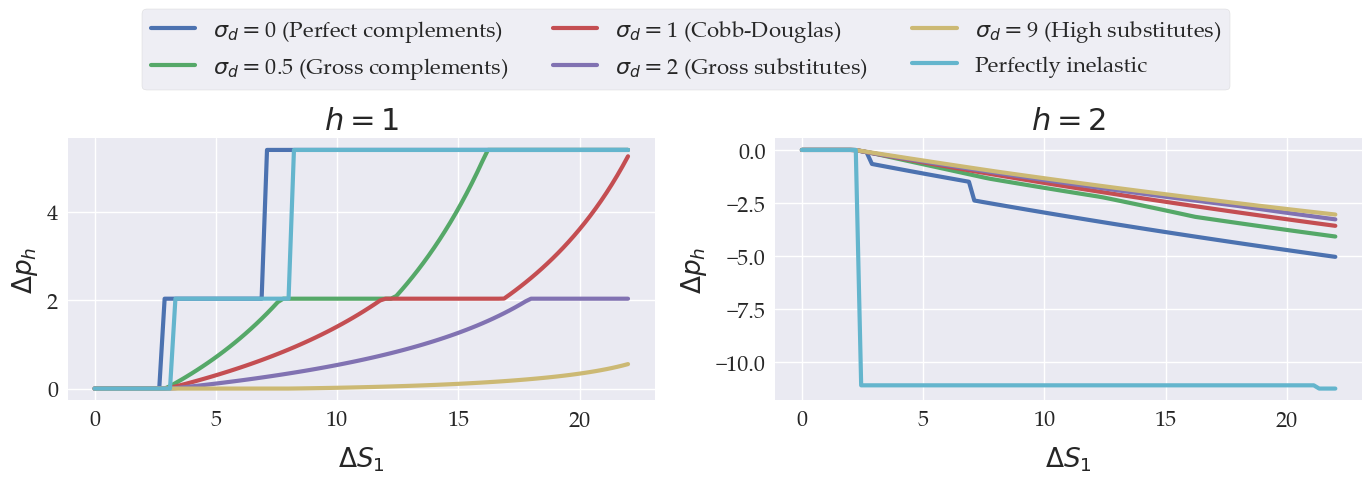

In [26]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    h = j+1
    
    df_tmp = (df_results['p']-df_results['p'].xs(0,level='S$_0$'))#/df_results['p'].xs(0,level='S$_0$')/
    df_tmp.xs(h,level='h').unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    # df_results.xs(h,level='h')['p'].unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    
    ax.set_xlabel(r'$\Delta S_1$', labelpad=10);
    ax.set_ylabel(r'$\Delta p_h$', labelpad = 5);
    ax.set_title(f"""$h={h}$""")
    
    
fig.legend(df_results.index.get_level_values('$\sigma_d$').sort_values().unique(),
           loc=9,ncol=math.ceil(len(df_results.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.25))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceH_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceH.pdf",edgecolor='k',bbox_inches='tight')

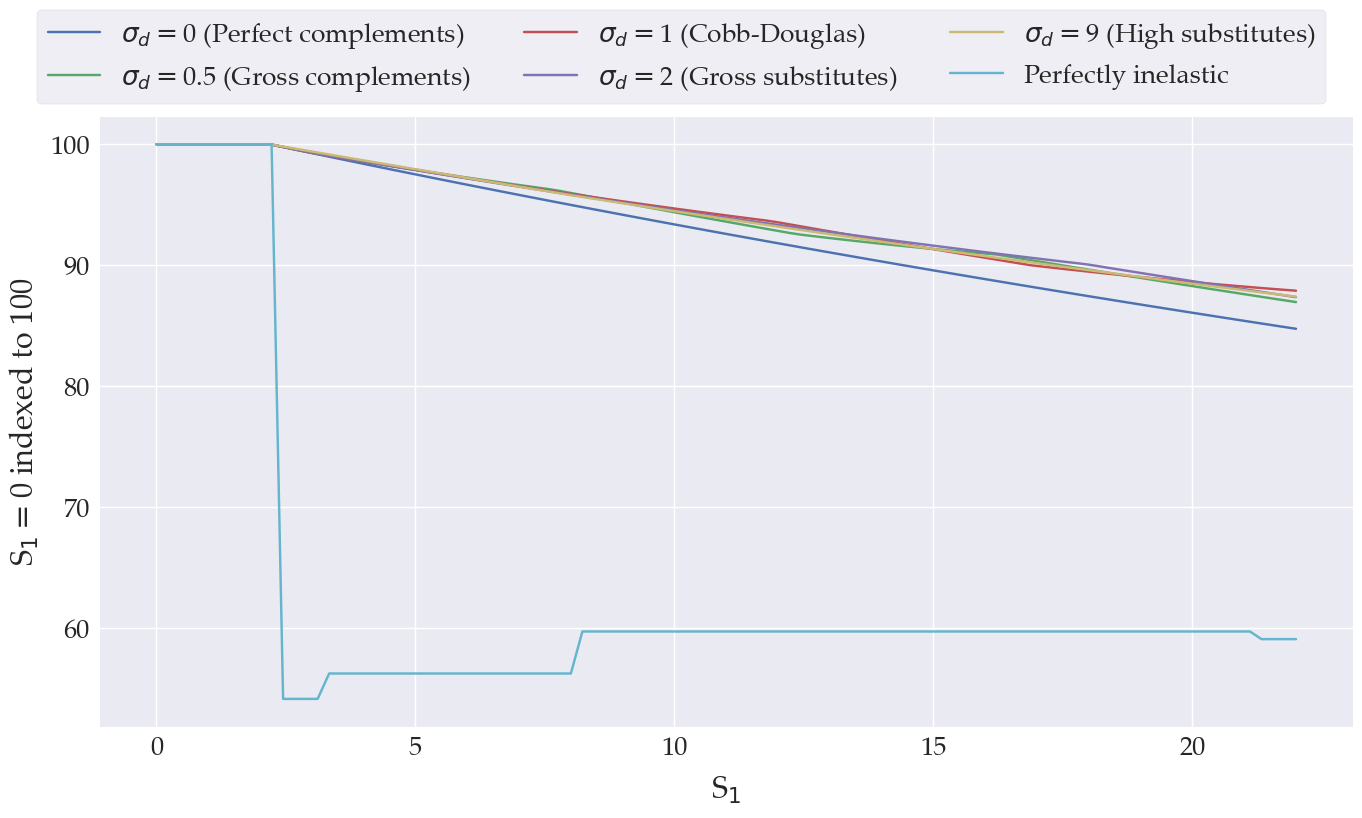

In [27]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df_tmp = df_results.xs(1,level='h')['p_index']
df_tmp.divide(df_tmp.xs(0,level='S$_0$')/100).unstack('$\sigma_d$').plot(ax=ax,legend=False)
ax.set_xlabel(r'S$_1$', labelpad=10);
ax.set_ylabel(r'S$_1=$0 indexed to 100', labelpad = 5);

fig.legend(df_results.index.get_level_values('$\sigma_d$').sort_values().unique(),
            loc=9,ncol=math.ceil(len(df_results.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.05))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceIndex_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceIndex.pdf",edgecolor='k',bbox_inches='tight')

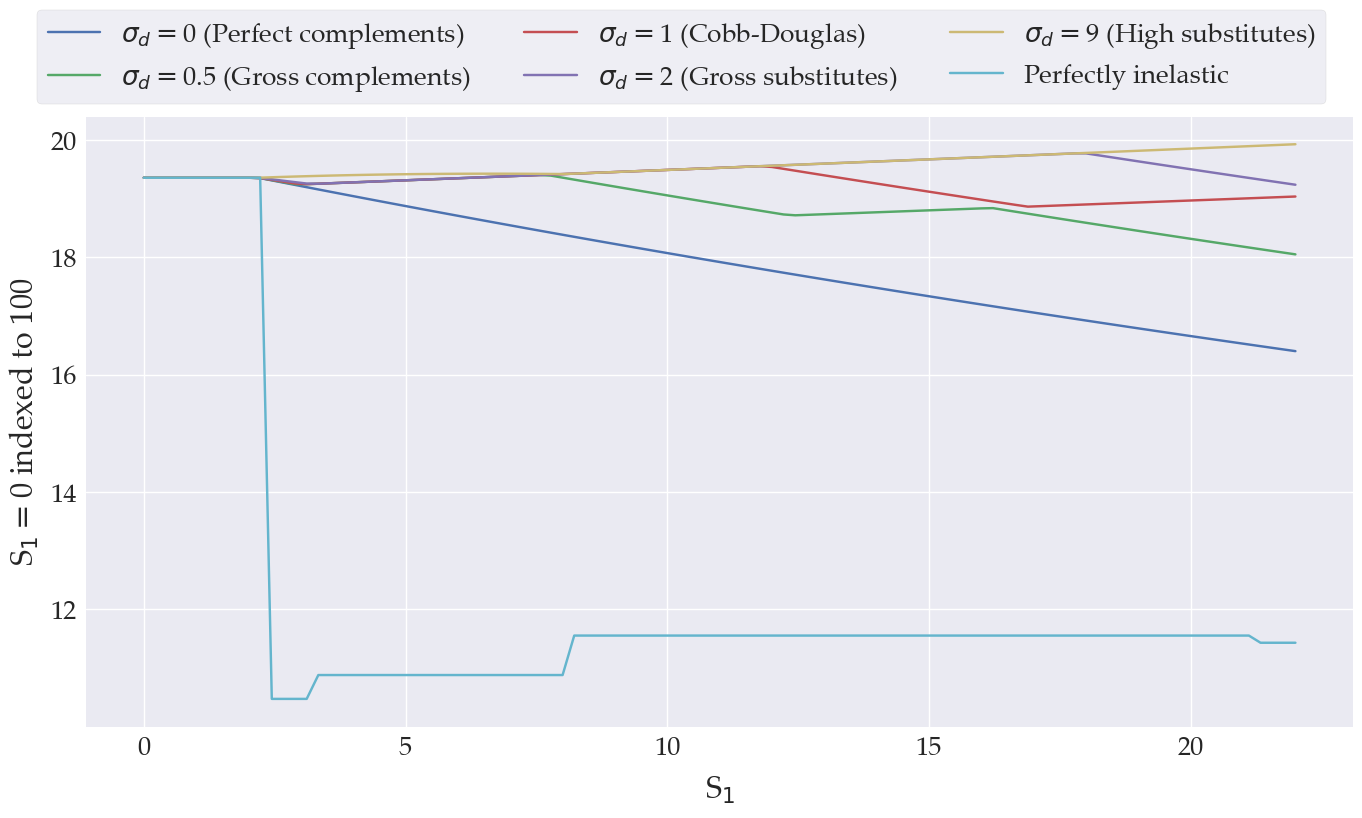

In [28]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df_tmp = df_results.xs(1,level='h')['p_t']
df_tmp.unstack('$\sigma_d$').plot(ax=ax,legend=False)
ax.set_xlabel(r'S$_1$', labelpad=10);
ax.set_ylabel(r'S$_1=$0 indexed to 100', labelpad = 5);

fig.legend(df_results.index.get_level_values('$\sigma_d$').sort_values().unique(),
            loc=9,ncol=math.ceil(len(df_results.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.05))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceT_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PriceT.pdf",edgecolor='k',bbox_inches='tight')

*Plot demand:*

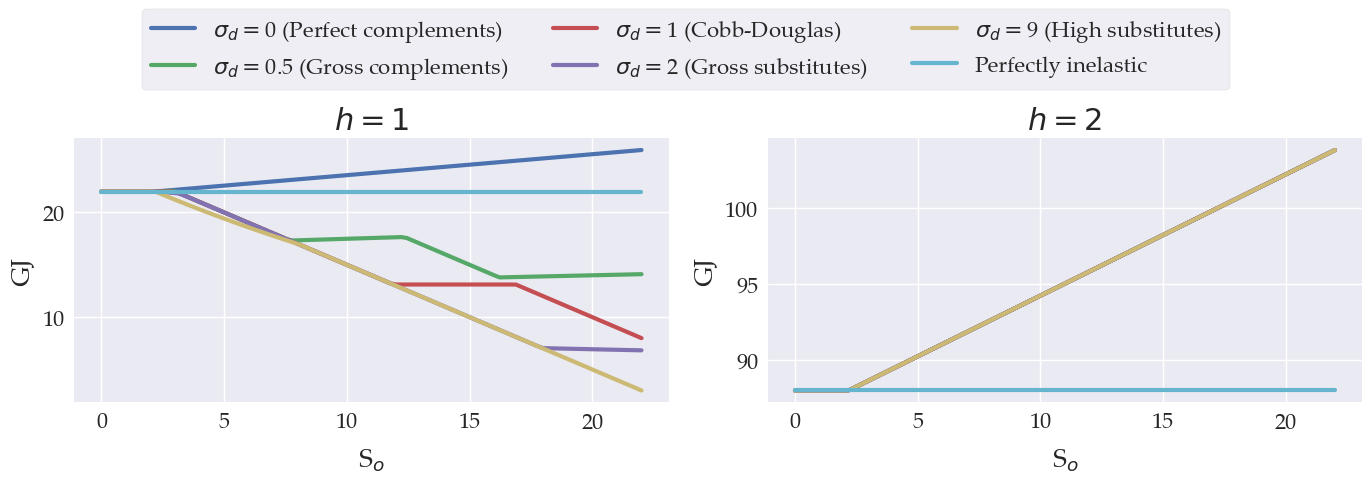

In [29]:
# %%capture
mult_graphs()
nplots = len(m.db['h'])
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    h = j+1
    
    df_results.xs(h,level='h')['D'].unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    ax.set_xlabel(r'S$_o$', labelpad=10);
    ax.set_ylabel(r'GJ', labelpad = 5);
    ax.set_title(f"""$h={h}$""")
    
    
fig.legend(df_results.index.get_level_values('$\sigma_d$').sort_values().unique(),
           loc=9,ncol=math.ceil(len(df_results.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.25))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_DemandH_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_DemandH.pdf",edgecolor='k',bbox_inches='tight')

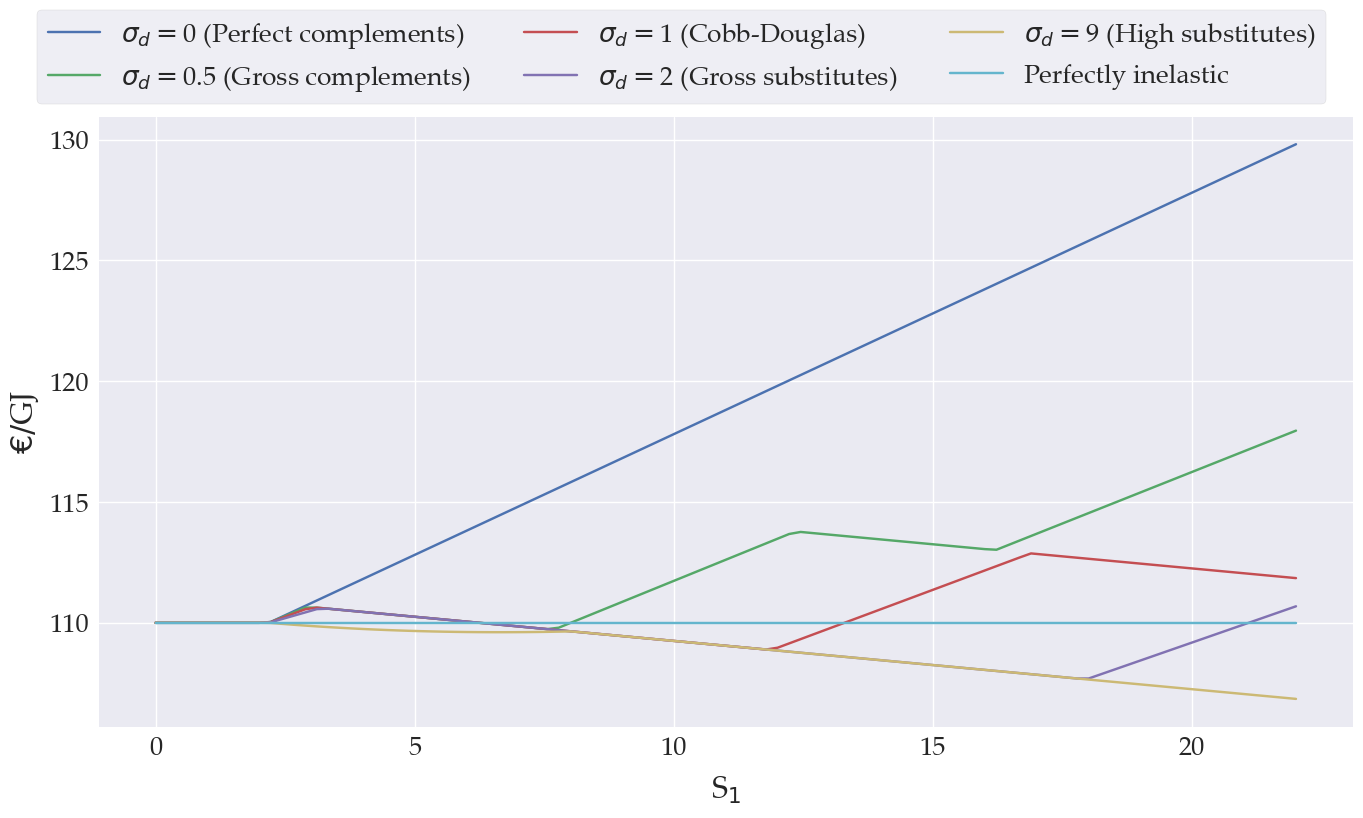

In [30]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df_results['D'].groupby(['$\sigma_d$','S$_0$']).agg('sum').unstack('$\sigma_d$').plot(ax=ax,legend=False)
ax.set_xlabel(r'S$_1$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);

fig.legend(df_results.index.get_level_values('$\sigma_d$').sort_values().unique(),
            loc=9,ncol=math.ceil(len(df_results.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.05))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_TotDemand_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_TotDemand.pdf",edgecolor='k',bbox_inches='tight')

*Plot practical capacity factor:*

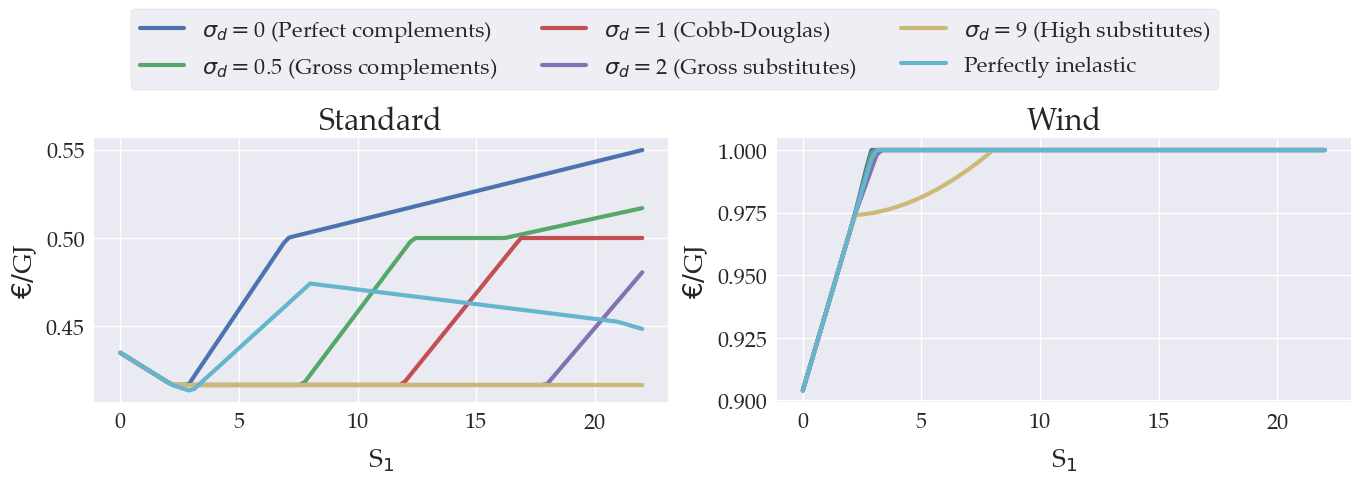

In [31]:
# %%capture
mult_graphs()
pt = [x for x in df_plants.index.get_level_values('Agent').unique() if x!='Solar PV']
nplots = len(pt)
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    agent = pt[j]
    
    df_plants.xs(agent,level='Agent')['PracticalCapacityFactor'].unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    ax.set_xlabel(r'S$_1$', labelpad=10);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_title(f"""{agent}""")
    
fig.legend(df_plants.index.get_level_values('$\sigma_d$').sort_values().unique(),
           loc=9,ncol=math.ceil(len(df_plants.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.25))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PCF_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_PCF.pdf",edgecolor='k',bbox_inches='tight')

*Plot marginal values:*

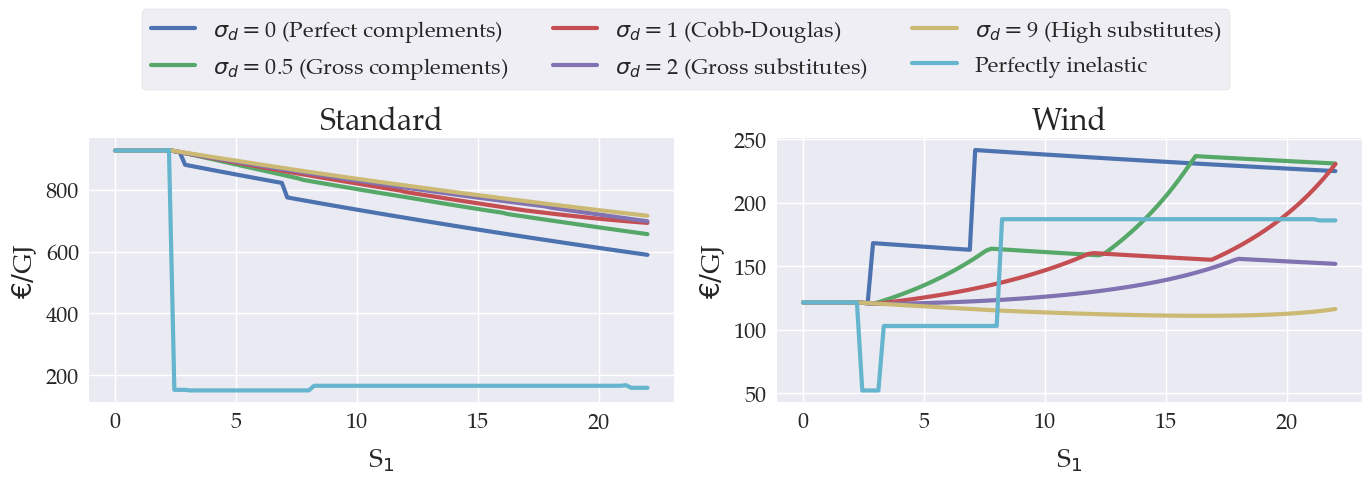

In [32]:
# %%capture
mult_graphs()
pt = [x for x in df_plants.index.get_level_values('Agent').unique() if x!='Solar PV']
nplots = len(pt)
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    agent = pt[j]
    
    df_plants.xs(agent,level='Agent')['marginalEconomicValue'].unstack('$\sigma_d$').plot(ax=ax,legend=False,linewidth=3)
    ax.set_xlabel(r'S$_1$', labelpad=10);
    ax.set_ylabel(r'$€/$GJ', labelpad = 5);
    ax.set_title(f"""{agent}""")
    
    
fig.legend(df_plants.index.get_level_values('$\sigma_d$').sort_values().unique(),
          loc=9,ncol=math.ceil(len(df_plants.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.25))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_mEV_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_mEV.pdf",edgecolor='k',bbox_inches='tight')

*Plot welfare:*

In [33]:
# def EV(df):
#     D_base = df['D_base'].unstack('h').values
#     D = df['D'].unstack('h').values
#     μ = df['μ'].unstack('h').values
#     σ_d = df['D_base'].unstack('h').index.get_level_values('$\sigma_d$').str.extract('([0-9][,.]*[0-9]*)')[0].astype(float).values
#     p_index_base = df['p_index_base'].xs(1,level='h').values
#     EV = [utility(D[i,:],μ[i,:],σ_d[i])*p_index_base[i] - utility(D_base[i,:],μ[i,:],σ_d[i])*p_index_base[i] for i in range(len(σ_d))]
#     return pd.Series(EV,index=df['D'].unstack('h').index,name='EV')
def EV(df):
    μ = df['μ'].unstack('h').values
    σ_d = df['D_base'].unstack('h').index.get_level_values('$\sigma_d$').str.extract('([0-9][,.]*[0-9]*)')[0].astype(float).values
    p = df['p'].unstack('h').values
    p_index_base = df['p_index_base'].xs(1,level='h').values
    EV = [indirect_utility(p[i,:],*(μ[i,:],σ_d[i],I))*p_index_base[i] - indirect_utility(p_base,*(μ[i,:],σ_d[i],I))*p_index_base[i] for i in range(len(σ_d))]
    return pd.Series(EV,index=df['D'].unstack('h').index,name='EV')

In [34]:
# Consumers
idx = df_results.index.get_level_values('$\sigma_d$')!='Perfectly inelastic'
df_cs1 = EV(df_results[idx])
df_cs1.index = pd.MultiIndex.from_tuples([(x,y,'Consumer') for x,y in zip(df_cs1.index.get_level_values('$\sigma_d$'),df_cs1.index.get_level_values('S$_0$'))],names=df_cs1.index.names+['Agent'])
df_cs2 = ((df_results.loc[~idx,'p_base']-df_results.loc[~idx,'p'])*df_results.loc[~idx,'D']).groupby(['$\sigma_d$','S$_0$']).agg('sum')
df_cs2.index = pd.MultiIndex.from_tuples([(x,y,'Consumer') for x,y in zip(df_cs2.index.get_level_values('$\sigma_d$'),df_cs2.index.get_level_values('S$_0$'))],names=df_cs2.index.names+['Agent'])
df_cs = df_cs1.append(df_cs2)

# Storage
df_st = ((1-λ)*df_results['p'].xs(2,level='h')-df_results['p'].xs(1,level='h'))*df_results.xs(1,level='h').index.get_level_values('S$_0$')
df_st.index = pd.MultiIndex.from_tuples([(x,y,'Storage') for x,y in zip(df_st.index.get_level_values('$\sigma_d$'),df_st.index.get_level_values('S$_0$'))],names=df_st.index.names+['Agent'])

# Combine all agents
df_ps = (df_plants['Profits']-df_plants['Profits'].xs(0,level='S$_0$')).rename('W').reorder_levels(df_cs1.index.names)
W = df_ps.append(df_cs.rename('W')).append(df_st.rename('W'))
W_neg, W_pos = W.clip(upper=0), W.clip(lower=0)

*Plot for wind 

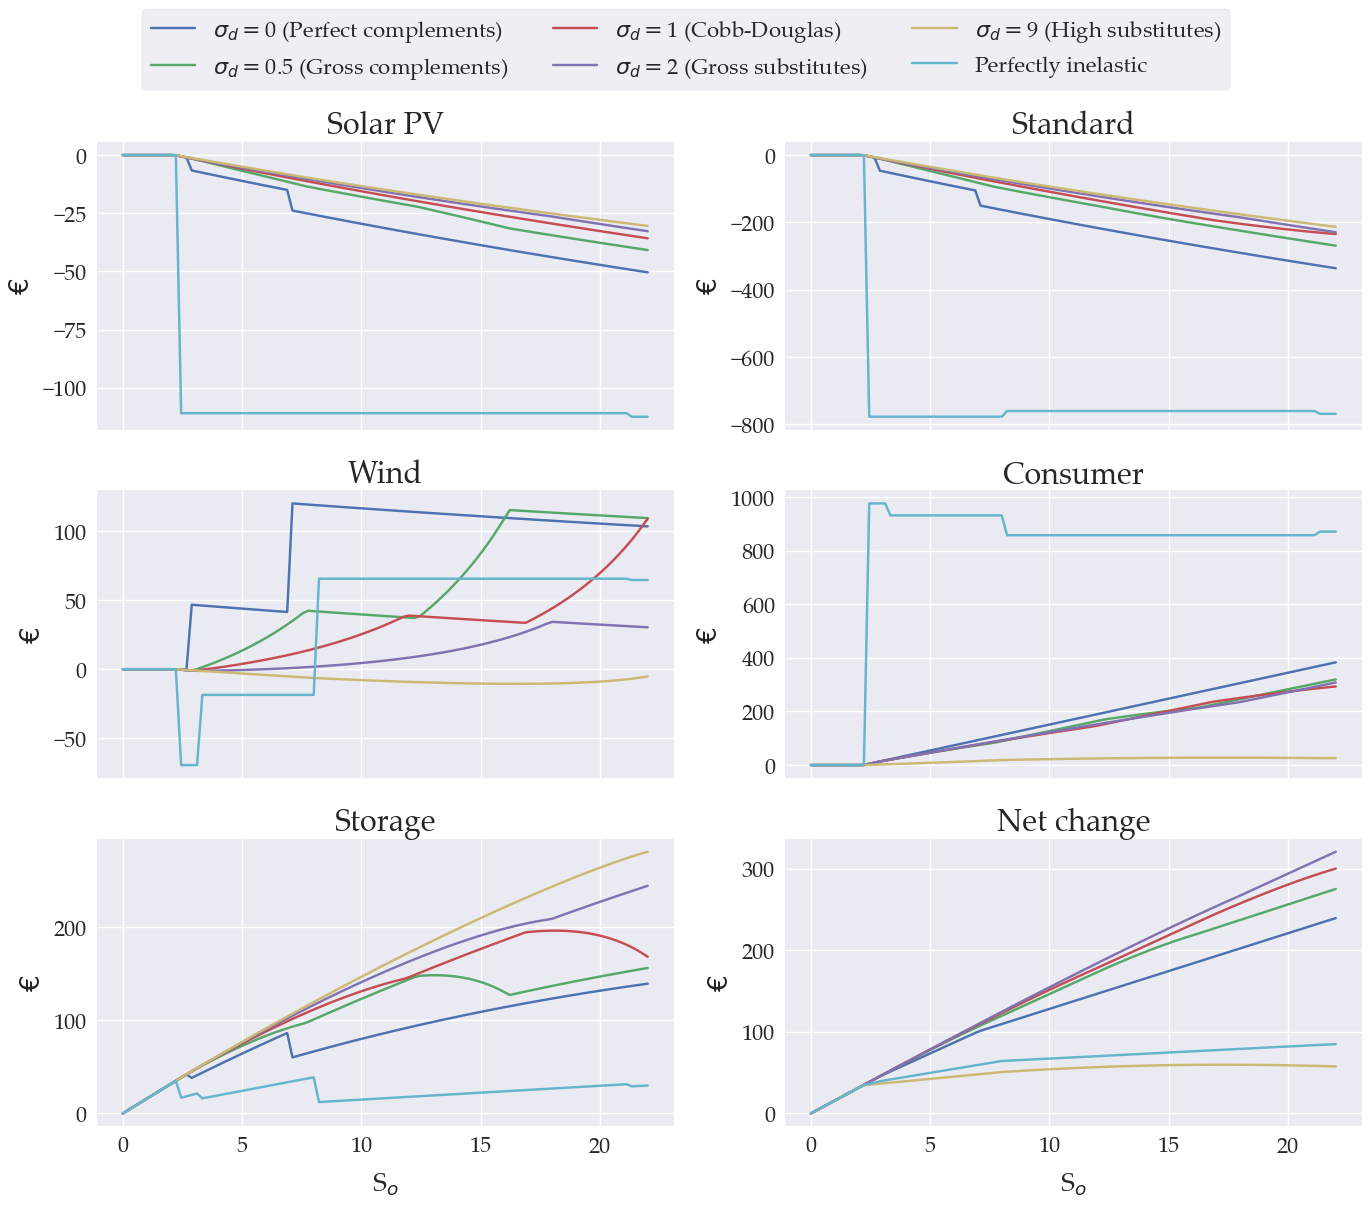

In [35]:
# %%capture
mult_graphs()
agent_grid = [x for x in W.index.get_level_values('Agent').unique()]
nplots = len(agent_grid)+1
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=False,sharex=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    if j<nplots-1:
        agent = agent_grid[j]
        W.xs(agent,level='Agent').unstack('$\sigma_d$').plot(ax=ax,legend=False)
        ax.set_title(f"""{agent}""")
    if j==nplots-1:
        df_tmp = W.groupby(W.droplevel('Agent').index.names).agg('sum').unstack('$\sigma_d$')
        df_tmp.plot(ax=ax,legend=False)
        ax.set_title('Net change')
    
    ax.set_xlabel(r'S$_o$', labelpad=10)
    ax.set_ylabel(r'$€$',labelpad=5)
    
fig.legend(W.index.get_level_values('$\sigma_d$').sort_values().unique(),
           loc=9,ncol=3,frameon=True,bbox_to_anchor=(0.5, 1.02))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Welfare1_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Welfare1.pdf",edgecolor='k',bbox_inches='tight')

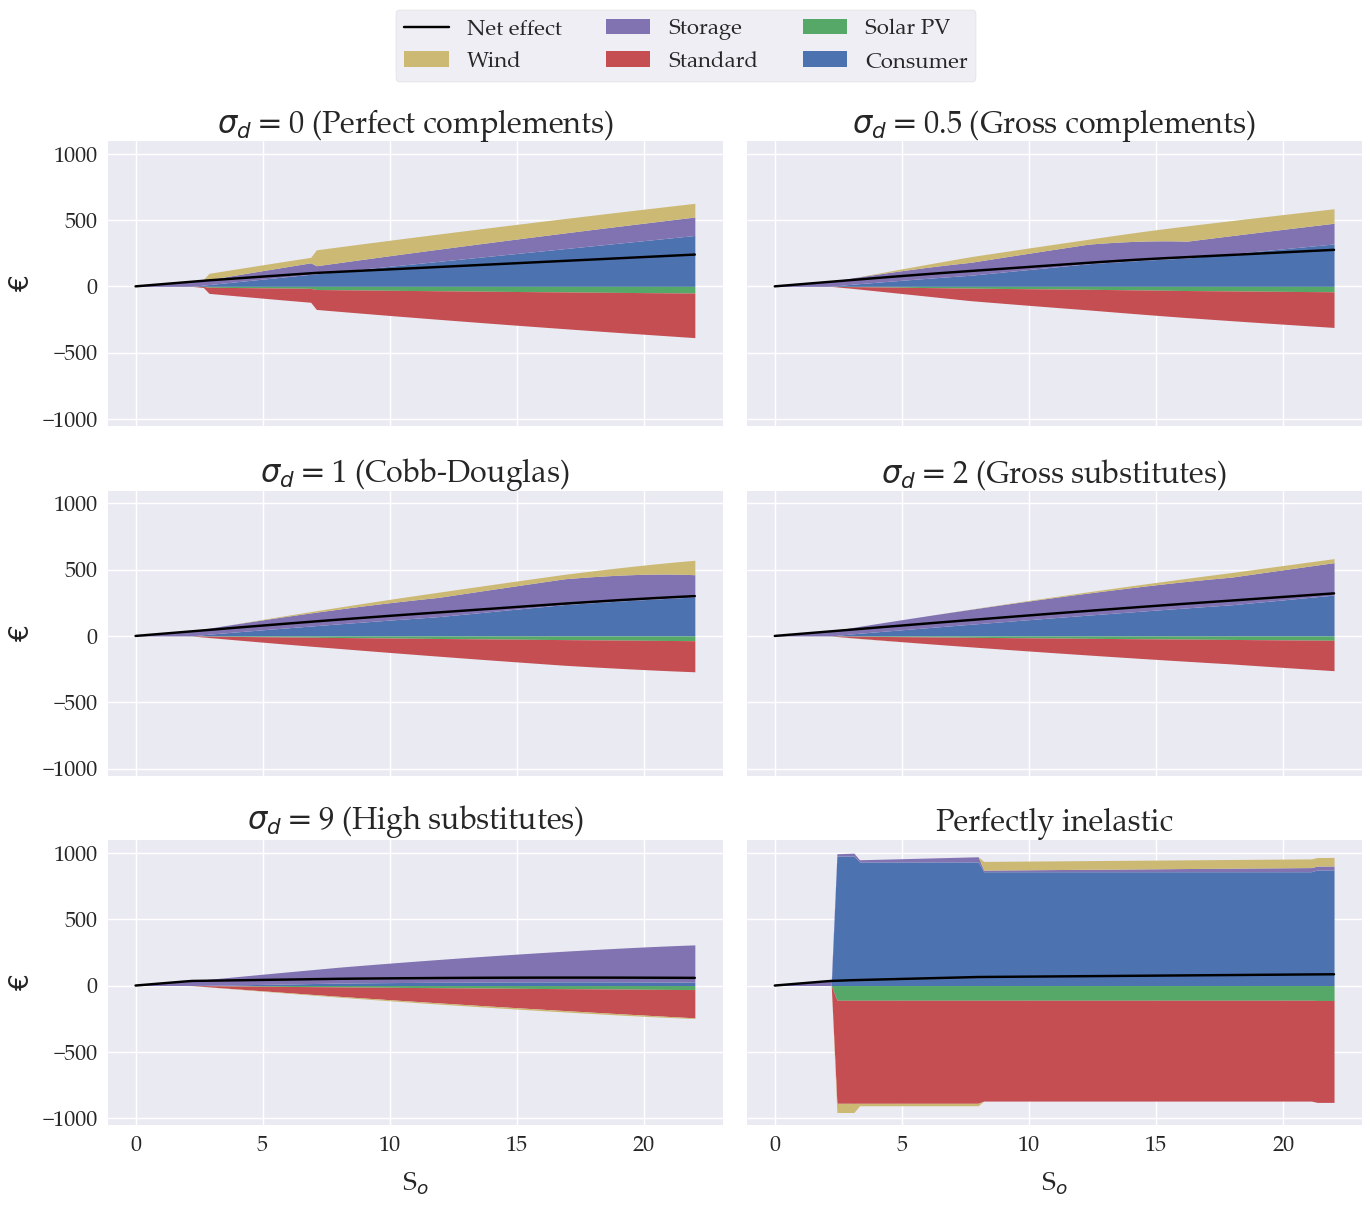

In [36]:
# %%capture
mult_graphs()
σ_d_grid_tmp = [x for x in W.index.get_level_values('$\sigma_d$').unique()]
nplots = len(σ_d_grid_tmp)
nrows = math.ceil(nplots/2)
fig,axes = plt.subplots(nrows,min(nplots,2),figsize=(14,(4*nrows)),sharey=True,sharex=True);
plt.subplots_adjust(hspace=0.35)
offset_N, offset_Arrow, offset_q = 1, 1, 3
for j in range(nplots):
    ax = plt.subplot(nrows,min(nplots,2),j+1)
    σ_d = σ_d_grid_tmp[j]
    
    # W_pos.xs(σ_d,level='$\sigma_d$').plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
    W_pos.xs(σ_d,level='$\sigma_d$').unstack('Agent').fillna(0).plot.area(ax=ax, stacked=True, linewidth=0.,legend=False)
    ax.set_prop_cycle(None)
    # W_neg.xs(σ_d,level='$\sigma_d$').rename(columns=lambda x: '_' + x).plot.bar(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
    W_neg.xs(σ_d,level='$\sigma_d$').unstack('Agent').fillna(0).rename(columns=lambda x: '_' + x).plot.area(ax=ax, stacked=True, linewidth=0.,legend=False)#, width=1.0)
    df_tmp = W.xs(σ_d,level='$\sigma_d$').groupby('S$_0$').agg('sum').fillna(0).reset_index()
    # df_tmp['S$_0$'] = df_tmp['S$_0$'].astype('str')
    # df_tmp.plot.scatter(ax=ax,x='S$_0$',y='W',color='black',s=35,marker='o')
    df_tmp.plot(ax=ax,x='S$_0$',y='W',color='black',legend=False)

    
    ax.set_xlabel(r'S$_o$', labelpad=10)
    ax.set_ylabel(r'$€$',labelpad=5)
    # ax.set_xticklabels(labels=[round(x,1) for x in W_pos.xs(σ_d,level='$\sigma_d$').index],rotation=90)
    ax.set_title(f"""{σ_d}""")
    
    
# fig.legend(['$\sigma_d=$'+str(x) for x in df_plants.index.get_level_values('$\sigma_d$').unique()],
#            loc=9,ncol=len(df_results.index.get_level_values('$\sigma_d$').unique()),frameon=True,bbox_to_anchor=(0.5, 1.15))
legend_elements = [mpl.lines.Line2D([0], [0],color='black', label='Net effect',markerfacecolor=None),#mpl.lines.Line2D([0], [0], marker='o',color='w', label='Net effect',markerfacecolor='black', markersize=10),
                   mpl.patches.Patch(facecolor=colors[4], edgecolor=None, label='Wind'),
                   mpl.patches.Patch(facecolor=colors[3], edgecolor=None, label='Storage'),
                   mpl.patches.Patch(facecolor=colors[2], edgecolor=None, label='Standard'),
                   mpl.patches.Patch(facecolor=colors[1], edgecolor=None, label='Solar PV'),
                   mpl.patches.Patch(facecolor=colors[0], edgecolor=None, label='Consumer')]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 0.94))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Welfare2_slides.pdf",facecolor='#FAFAFA',edgecolor='k')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_Welfare2.pdf",edgecolor='k')

*Plot emissions:*

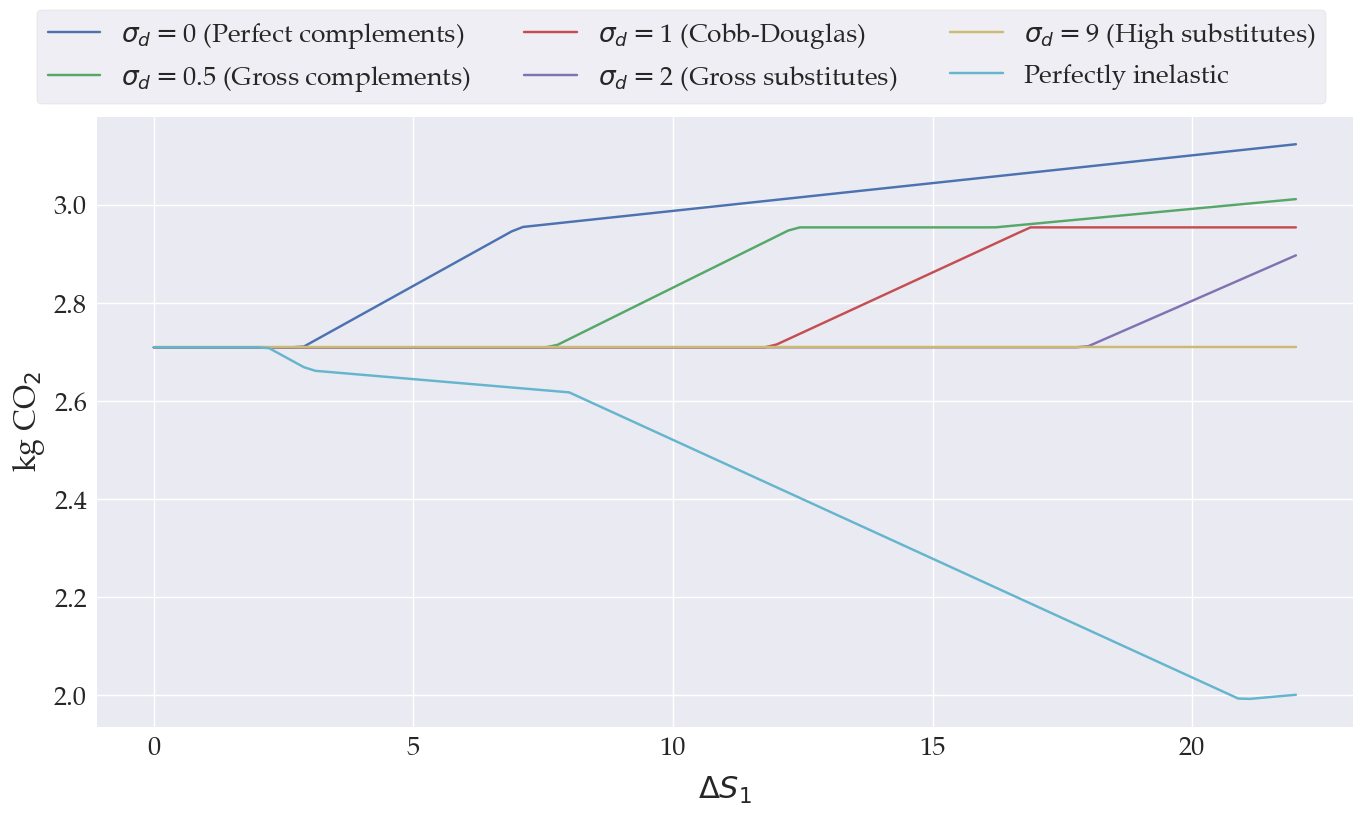

In [37]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df_results['CO2'].groupby(['$\sigma_d$','S$_0$']).agg('mean').unstack('$\sigma_d$').plot(ax=ax,legend=False)
ax.set_xlabel(r'$\Delta S_1$', labelpad=10);
ax.set_ylabel(r'kg CO$_2$', labelpad = 5);

fig.legend(df_results.index.get_level_values('$\sigma_d$').sort_values().unique(),
            loc=9,ncol=math.ceil(len(df_results.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.05))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_CO2_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_CO2.pdf",edgecolor='k',bbox_inches='tight')

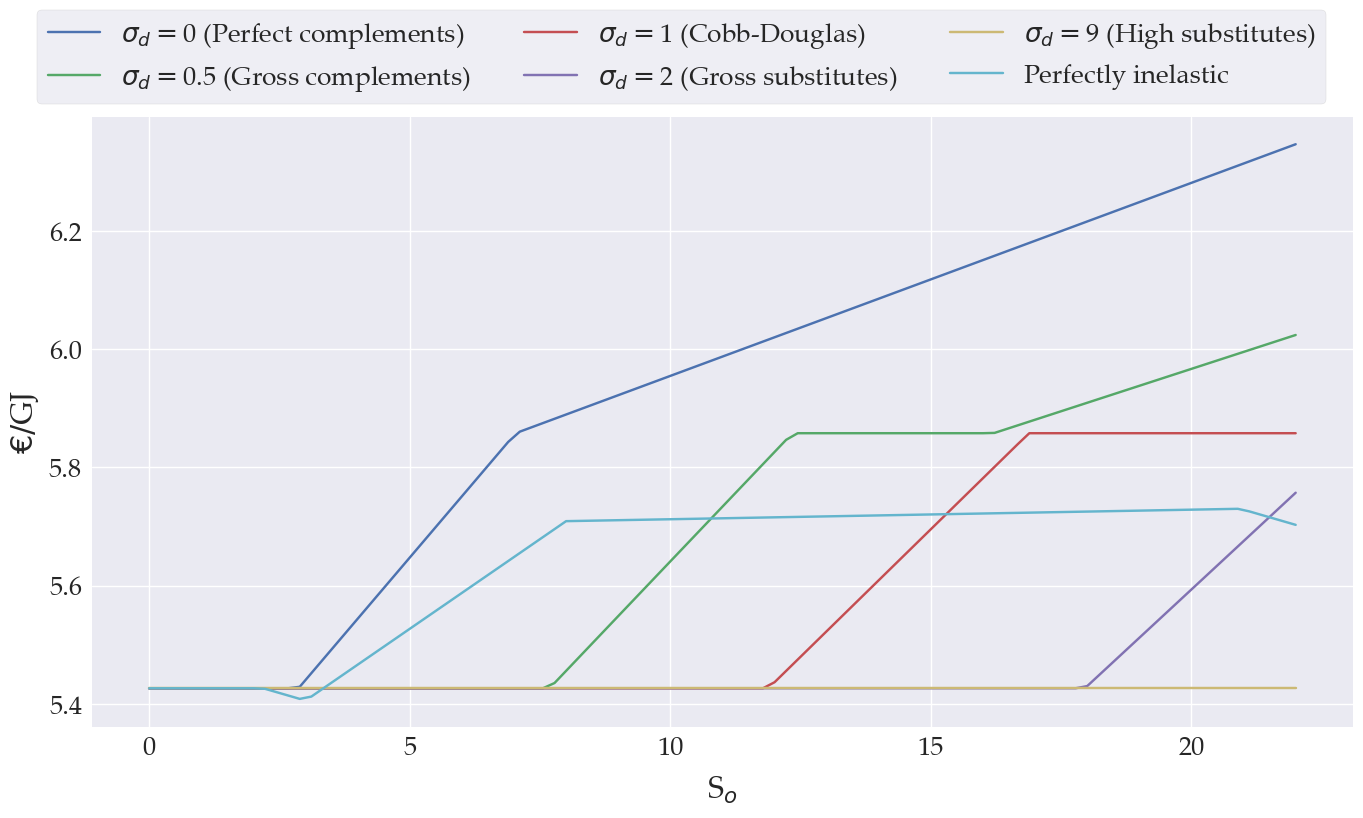

In [38]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df_results['SO2'].groupby(['$\sigma_d$','S$_0$']).agg('mean').unstack('$\sigma_d$').plot(ax=ax,legend=False)
ax.set_xlabel(r'S$_o$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);

fig.legend(df_results.index.get_level_values('$\sigma_d$').sort_values().unique(),
            loc=9,ncol=math.ceil(len(df_results.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.05))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_SO2_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_SO2.pdf",edgecolor='k',bbox_inches='tight')

*Are flexible demand and storage strategic complements or subsitutes?*

In [39]:
df = pd.DataFrame()

# Set CES share parameters equal to 
μ = μs[0]

for S0 in S0_grid:
    
    for σ_d in σ_d_grid[1:]:
        
        # Reset prices:
        p_tmp = p_base.copy()
        
        # Make index
        index = pd.MultiIndex.from_tuples([(σ_d,S0,h) for h in [1,2]],names=['$\sigma_d$','S$_0$','h'])

        # Solve NonLinear programming model:
        sol = {}
        for i in range(len(d_σ_s_grid[σ_d])):
            σ_s = d_σ_s_grid[σ_d][i]
            sol[i] = minimize(
                    fun = MSE_excess_supply,
                    x0=p_tmp,
                    bounds = ((np.finfo(float).eps, np.inf), (np.finfo(float).eps, np.inf),),
                    args=(mc,q,σ_s,μ,σ_d,I,S0,λ),
                    )
            p_tmp = sol[i]['x'] if (sol[i]['success']) & (sol[i]['fun']<1) else sol[i-1]['x']
        # p_tmp = fsolve(excess_supply,x0=p_tmp,args=(mc,q,0.1,μ,σ_d,I,S0,λ))

        if ((1-λ)*p_tmp[1]>=p_tmp[0]):
            df_r_tmp = pd.Series(p_tmp,index=index,name='p').to_frame()
            df = df.append(df_r_tmp)

df = df.rename(σ_d_labels,level='$\sigma_d$').sort_index().unstack('h').sort_index()
idx = df.index.get_level_values('$\sigma_d$')==σ_d_labels[0]
idx2 = df_results.sort_index().unstack('h').index.get_level_values('$\sigma_d$')==σ_d_labels[0]
df.loc[idx,'p'] = df_results.unstack('h')['p'].sort_index()[idx2].values
df['π'] = (1-λ)*df[('p',2)] - df[('p',1)]

KeyError: -1

In [ ]:
one_graph()
fig, ax = plt.subplots(1,1,figsize = (14,8))
df['π'].unstack('$\sigma_d$').plot(ax=ax,legend=False)
ax.set_xlabel(r'S$_0$', labelpad=10);
ax.set_ylabel(r'$€/$GJ', labelpad = 5);

fig.legend(df.index.get_level_values('$\sigma_d$').sort_values().unique(),
            loc=9,ncol=math.ceil(len(df.index.get_level_values('$\sigma_d$').unique())/2),frameon=True,bbox_to_anchor=(0.5, 1.05))
fig.tight_layout();
fig.subplots_adjust(top=0.9);
if slides:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_StorageValue2_slides.pdf",facecolor='#FAFAFA',edgecolor='k',bbox_inches='tight')
else:
    fig.savefig(f"{out_folder}\\mBasicInt_Storage_StorageValue2.pdf",edgecolor='k',bbox_inches='tight')

In [ ]:
s_base = p_base*D_base/I
σ_2_max = s_base[0]*(D_base[1]+(1-λ)*D_base[0])/(s_base[0]*D_base[1]-(1-λ)*D_base[0]*(1-s_base[0]))
σ_1_max = s_base[1]*(D_base[1]+(1-λ)*D_base[0])/(D_base[1]*(s_base[1]-1)+(1-λ)*s_base[1]*D_base[0])

In [ ]:
σ_2_max

In [ ]:
σ_1_max

In [ ]:
df_tmp = df_results.unstack('h')
idx = df_tmp[('p',1)]<df_tmp[('p_base',1)]
df_tmp[idx]